In [1]:
import os, sys
sys.path.append("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,"
from pathlib import Path
from types import SimpleNamespace
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from PIL import Image, ImageDraw
import torch
import torch.nn.functional as F
from safetensors.torch import load_file
import lovely_tensors as lt

from musubi_tuner.dataset.image_video_dataset import resize_image_to_bucket
from musubi_tuner.networks import lora_framepack
from musubi_tuner.frame_pack.clip_vision import hf_clip_vision_encode
from musubi_tuner.frame_pack.framepack_utils import load_vae, load_text_encoder1, load_text_encoder2, load_image_encoders
from musubi_tuner.frame_pack.hunyuan import encode_prompt_conds, vae_encode, vae_decode
from musubi_tuner.frame_pack.hunyuan_video_packed import load_packed_model, attn_cache
from musubi_tuner.frame_pack.k_diffusion_hunyuan import sample_hunyuan
from musubi_tuner.frame_pack.utils import crop_or_pad_yield_mask
from musubi_tuner.fpack_1fmc_generate import read_image, getres
from musubi_tuner.wan_generate_video import merge_lora_weights
from preproc_utils import get_text_preproc, getres, preproc_image, preproc_mask, prepare_image_inputs, prepare_control_inputs
from attn_utils import get_text_inds_from_dict, get_attn_map

device = torch.device('cuda:0')
lt.monkey_patch()

2025-07-27 12:30:17.553678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753587017.572364   79867 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753587017.578143   79867 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-27 12:30:17.612846: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:numexpr.utils:Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment 

Trying to import sageattention
Successfully imported sageattention


In [ ]:
dit_path = "/data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors"
vae_path = "/data/stale/patrickkwon/video/stable-diffusion-webui/models/VAE/hunyuan-video-t2v-720p-vae.pt"
text_encoder1_path = "/shared/video/ComfyUI/models/text_encoders/llava_llama3_fp16.safetensors"
text_encoder2_path = "/shared/video/ComfyUI/models/text_encoders/clip_l.safetensors"
image_encoder_path = "/shared/video/ComfyUI/models/clip_vision/sigclip_vision_patch14_384.safetensors"
lora_path = "/data/stale/patrickkwon/video/stable-diffusion-webui/models/Lora/framepack/fpack_1fmc_bg_lora/bg_lora_1000.safetensors"

model = load_packed_model(device, dit_path, 'sageattn', device)
model.to(device)
model.eval().requires_grad_(False)

merge_lora_weights(lora_framepack, model, 
    SimpleNamespace(
        lora_weight = [lora_path], lora_multiplier = [1.0], 
        include_patterns=None, exclude_patterns=None, lycoris=None,
        save_merged_model=False
    ), 
device, None)
target_index = [1]
control_indices = [0,10]

vae = load_vae(vae_path, 32, 128, device)

tokenizer1, text_encoder1 = load_text_encoder1(SimpleNamespace(text_encoder1=text_encoder1_path), False, device)
tokenizer2, text_encoder2 = load_text_encoder2(SimpleNamespace(text_encoder2=text_encoder2_path))
feature_extractor, image_encoder = load_image_encoders(SimpleNamespace(image_encoder=image_encoder_path))

INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors, device=cuda:0
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors, info=<All keys matched successfully>
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from /data/stale/patrickkwon/video/stable-diffusion-webui/models/Lora/framepack/fpack_1fmc_bg_lora/bg_lora_1000.safetensors with multiplier 1.0
INFO:musubi_tuner.networks.lora:create LoRA network from weights
INFO:musubi_tuner.networks.lora:create LoRA for U-Net/DiT: 440 modules.
INFO:musubi_tuner.networks.lora:weights are merged
INFO:musubi_tuner.wan_generate_video:LoRA weights loaded
INFO:musubi_tuner.hunyuan_model.vae:Loading 3D VAE model 

In [ ]:
# prompt = 'Chinese Ancient Wuxia. The red-clothed maiden and the burly man engage in a fierce battle on the stage. The maiden moves gracefully with agile techniques, while the man is strong and powerful. The surrounding crowd cheers excitedly.'
# height, width = 336, 672
# image_path = "outputs/vistory_tmp/vistory_04_04_bg.png"
# control_image_paths = ["outputs/vistory_tmp/vistory_04_04_bg.png", "outputs/vistory_tmp/vistory_04_04_chara.png"]
# control_image_mask_paths = ["outputs/vistory_tmp/vistory_04_04_mask.png", ""]
# seed = 48

# in_folder = Path("/data/whisperer/outputs/20250716_141340/[PANEL-1]")
# prompt = "Mr. Qin sits on a bench in the waiting hall, lost in thought"

in_folder = Path("/data/whisperer/vlm/tmp/07_1116695226_whitebg/2")
prompt = (in_folder / "prompt.txt").read_text()
image_paths = [str(in_folder / "backg_img.png")]
control_image_paths = [str(in_folder / "backg_img.png"), str(in_folder / "chara_img.png")]
control_image_mask_paths = [str(in_folder / "mask_img.png"), ""]

seed = 24
width, height = getres(*read_image(image_paths[0]).size)


FileNotFoundError: [Errno 2] No such file or directory: '/data/whisperer/outputs/20250716_141340/[PANEL-1]/backg_img.png'

In [12]:
## Text Preprocessing
text_kwargs = get_text_preproc(prompt, text_encoder1, text_encoder2, tokenizer1, tokenizer2,  device=device)

## Image Preprocessing
image_kwargs, img_np = prepare_image_inputs(
    image_paths, feature_extractor, image_encoder, 
    width=width, height=height, 
    target_index=target_index, device=device, dtype=torch.bfloat16)

## Control Preprocessing
control_kwargs, control_nps = prepare_control_inputs(
    control_image_paths, control_image_mask_paths, vae,
    width=width, height=height, 
    control_indices=control_indices)

# entity_masks = torch.cat([preproc_mask(e_mask, width, height, invert=False)[0] for e_mask in entity_mask_paths], 1)

  0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Activate Attention Caching for Exp.
INFO:root:1000.0: hidden_states: tensor[1, 2652, 3072] bf16 n=8146944 (16Mb) x∈[-16.000, 18.625] μ=-0.018 σ=1.547 cuda:0
INFO:root:1000.0: encoder_hidden_states: tensor[1, 763, 3072] bf16 n=2343936 (4.5Mb) x∈[-2.736e+03, 2.864e+03] μ=0.316 σ=160.000 cuda:0
INFO:root:1000.0: temb: tensor[1, 3072] bf16 6Kb x∈[-9.312, 20.000] μ=-0.107 σ=0.965 cuda:0
INFO:root:1000.0: attention_mask: tensor[1, 3415, 3415] bf16 n=11662225 (22Mb) x∈[0., 0.] μ=0. σ=0. -Inf! cuda:0
INFO:root:1000.0: rope_freqs: tensor[1, 2652, 256] n=678912 (2.6Mb) x∈[-1.000, 1.000] μ=0.371 σ=0.602 cuda:0
INFO:root:1000.0: defaultdict(<class 'list'>, {'clean_latents': [(0, 884), (884, 1768)], 'noise': [(1768, 2652)], 'image_embeddings': [(2652, 3381)], 'text_embeddings': [(3381, 3415)]})
/data/whisperer/related/framepackbase/musubi-tuner/src/practice/../musubi_tuner/frame_pack/hunyuan_video_packed.py:794: UserWarning: You are using Attention Mask, but sageattn does not support atte

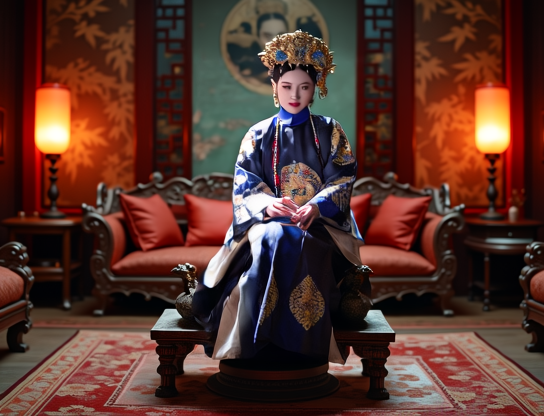

In [ ]:
num_inference_steps=25
seed = np.random.randint(2**31)
# seed = 2105350387 1989424941
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)

attn_cache.clear()
results = sample_hunyuan(
    transformer=model, sampler='unipc', width=width, height=height, frames=1,
    real_guidance_scale=1.0, distilled_guidance_scale=10.0, guidance_rescale=0.0, shift=None,
    num_inference_steps=num_inference_steps,
    generator=generator, device=device, dtype=torch.bfloat16,
    cache_results=True, cache_layers = [], 
    clean_latent_bbox=None,
    use_attention_masking=[],
    entity_masks=None,
    **text_kwargs, 
    **image_kwargs,
    **control_kwargs
)
history_pixels = torch.cat([
    vae_decode(results[:, :, i:i + 1, :, :], vae).cpu() for i in range(results.shape[2])
], dim=2)
result_img = (torch.clamp(((history_pixels[0,:,0,:,:]+1.0)/2.0).permute(1,2,0).cpu(), 0.0, 1.0) * 255.).numpy().astype(np.uint8)
result_img = np.concatenate([result_img, np.ones(result_img.shape[:2] + (1, ))*255], axis=-1).astype(np.uint8)

# Image.fromarray(np.concatenate(control_nps + [result_img], axis=1))
Image.fromarray(result_img)

In [25]:
with torch.autocast(device_type=device.type, dtype=text_encoder1.dtype), torch.no_grad():
    llama_vec, clip_l_pooler, llama_strtokens = encode_prompt_conds(
        prompt, text_encoder1, text_encoder2, tokenizer1, tokenizer2, custom_system_prompt=None, return_tokendict=True
    )
    llama_vec = llama_vec.to(device, dtype=torch.bfloat16)
    clip_l_pooler = clip_l_pooler.to(device, dtype=torch.bfloat16)
    llama_vec, llama_attention_mask = crop_or_pad_yield_mask(llama_vec, length=512)

llama_vec_n = torch.zeros_like(llama_vec).to(device, dtype=torch.bfloat16)
clip_l_pooler_n = torch.zeros_like(clip_l_pooler).to(device, dtype=torch.bfloat16)
llama_vec_n, llama_attention_mask_n = crop_or_pad_yield_mask(llama_vec_n, length=512)

In [24]:
# preprocess image:
def preproc_image(image_path):
    image_pil = Image.open(image_path).convert("RGB")
    image_np = resize_image_to_bucket(np.array(image_pil), (width, height))
    image_tensor = (torch.from_numpy(image_np).float() / 127.5 - 1.0).permute(2,0,1)[None, :, None]
    return image_tensor, image_np

def preproc_mask(mask_path):
    if mask_path == '':
        image_pil = Image.new("L", (width // 8, height // 8), 255)
    else:
        image_pil = Image.open(mask_path).convert("L")
    image_np = resize_image_to_bucket(np.array(image_pil), (width // 8, height // 8))
    image_tensor = (torch.from_numpy(image_np).float() / 255.0)[None, None, None, :, :]
    return image_tensor, image_np

img_tensor, img_np = preproc_image(image_path)
with torch.no_grad():
    image_encoder_output = hf_clip_vision_encode(img_np, feature_extractor, image_encoder)
image_encoder_last_hidden_state = image_encoder_output.last_hidden_state.to(device, dtype=torch.bfloat16)
# start_latent = vae_encode(img_tensor, vae).cpu()

latent_indices = torch.tensor([target_index], dtype=torch.int64)  # 1x1 latent index for target image

control_latents, control_nps = [], []
for i, (control_image_path, control_mask_path) in enumerate(zip(control_image_paths, control_image_mask_paths)):
    c_img_tensor, c_img_np = preproc_image(control_image_path)
    c_img_latent = vae_encode(c_img_tensor, vae).cpu()
    
    c_mask_image, c_mask_np = preproc_mask(control_mask_path)
    c_img_latent = c_img_latent * c_mask_image
    control_latents.append(c_img_latent)
    control_nps.append(np.concatenate([c_img_np, resize_image_to_bucket(c_mask_np, (width, height))[..., None]], -1))
clean_latents = torch.cat(control_latents, dim=2)  # (1, 16, num_control_images, H//8, W//8)

clean_latent_indices = torch.tensor([control_indices], dtype=torch.int64)

  0%|          | 0/25 [00:00<?, ?it/s]

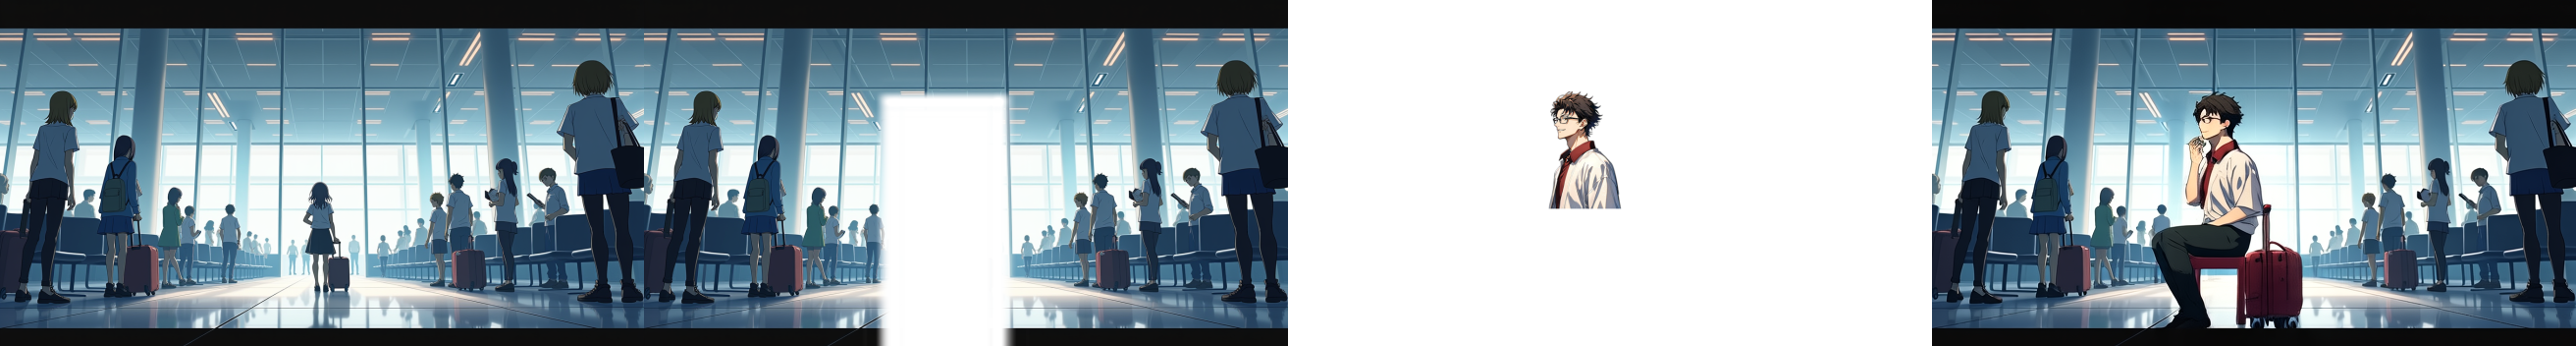

In [27]:
real_guidance_scale=1.0
distilled_guidance_scale=10.0
guidance_rescale=0.0
num_inference_steps=25
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)

attn_cache.clear()
results = sample_hunyuan(
    transformer=model,
    sampler='unipc',
    width=width,
    height=height,
    frames=1,
    real_guidance_scale=real_guidance_scale,
    distilled_guidance_scale=distilled_guidance_scale,
    guidance_rescale=guidance_rescale,
    shift=None,
    num_inference_steps=num_inference_steps,
    generator=generator,
    prompt_embeds=llama_vec,
    prompt_embeds_mask=llama_attention_mask,
    prompt_poolers=clip_l_pooler,
    negative_prompt_embeds=llama_vec_n,
    negative_prompt_embeds_mask=llama_attention_mask_n,
    negative_prompt_poolers=clip_l_pooler_n,
    device=device,
    dtype=torch.bfloat16,
    image_embeddings=image_encoder_last_hidden_state,
    latent_indices=latent_indices,
    clean_latents=clean_latents,
    clean_latent_indices=clean_latent_indices,
    clean_latents_2x=None,
    clean_latent_2x_indices=None,
    clean_latents_4x=None,
    clean_latent_4x_indices=None,
    cache_results=False,
    cache_layers = [
        'transformer_blocks.2', 'transformer_blocks.8', 'transformer_blocks.14', 
        'single_transformer_blocks.0', 'single_transformer_blocks.9', 'single_transformer_blocks.18', 
        'single_transformer_blocks.27', 'single_transformer_blocks.36', 
    ]
)

history_pixels = torch.cat([
    vae_decode(results[:, :, i:i + 1, :, :], vae).cpu() for i in range(results.shape[2])
], dim=2)
result_img = (torch.clamp(((history_pixels[0,:,0,:,:]+1.0)/2.0).permute(1,2,0).cpu(), 0.0, 1.0) * 255.).numpy().astype(np.uint8)

Image.fromarray(np.concatenate(
    [np.concatenate([img_np, np.ones(img_np.shape[:2] + (1, ))*255], axis=-1).astype(np.uint8)] + \
    control_nps + \
    [np.concatenate([result_img, np.ones(result_img.shape[:2] + (1, ))*255], axis=-1).astype(np.uint8)], 
axis=1))

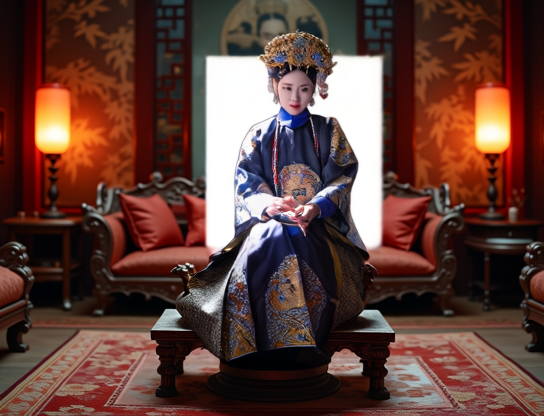

In [11]:
Image.fromarray(np.concatenate([result_img, np.ones(result_img.shape[:2] + (1, ))*255], axis=-1).astype(np.uint8))

torch.Size([1, 24, 3415, 3415])
torch.Size([1, 24, 2652, 763])
torch.Size([1, 24, 3, 26, 34, 763])
torch.Size([1, 763, 26, 34])
torch.Size([1, 34, 26, 34])


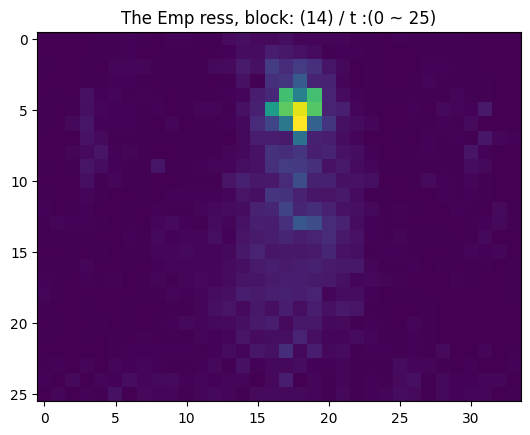

In [7]:
# attention_probs = attn_cache['transformer_blocks.0'][700][:,:,:2646,2646:]
# dict_keys([1000, 976, 956, 932, 904, 880, 852, 824, 796, 764, 732, 700, 664, 628, 592, 548, 508, 464, 416, 366, 314, 258, 200, 137, 71])

timesteps = sorted(list(attn_cache['transformer_blocks.2'].keys()), reverse=False)
token_H, token_W, token_C = height // 16, width // 16, len(control_indices) + len(latent_indices)
hidden_size = token_H * token_W * token_C

block = 14
t_0, t_1 = 0, 25
# inds = [7,8,9,10,11]
inds = [4,5,6]
token_len = len(llama_strtokens)
title = " ".join([llama_strtokens[x] for x in inds]) + f", block: ({block}) / t :({t_0} ~ {t_1})"

# attention_probs = attn_cache[f'transformer_blocks.{block}'][timesteps[t]]
attention_probs = sum(attn_cache[f'transformer_blocks.{block}'][timesteps[t]] for t in range(t_0, t_1))
print(attention_probs.shape)
attention_map = attention_probs[:,:,:hidden_size,hidden_size:]
print(attention_map.shape)
attention_map = rearrange(attention_map, 'B A (C H W) D -> B A C H W D', H=token_H, W=token_W)
print(attention_map.shape)
attention_map = attention_map[:,:,2,:,:,:].sum(1).squeeze(1).permute(0,3,1,2)
print(attention_map.shape)
attention_map = attention_map[:,729:,:,:]
print(attention_map.shape)

attention_image = attention_map[0,inds].mean(axis=0).to(dtype=torch.float32).cpu().numpy()

fig, ax = plt.subplots()
ax.imshow(attention_image)
ax.set_title(title)
plt.show()

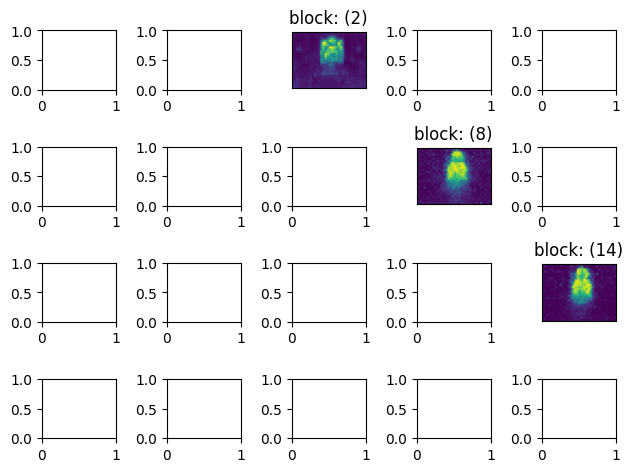

In [10]:
# attention_probs = attn_cache['transformer_blocks.0'][700][:,:,:2646,2646:]
# dict_keys([1000, 976, 956, 932, 904, 880, 852, 824, 796, 764, 732, 700, 664, 628, 592, 548, 508, 464, 416, 366, 314, 258, 200, 137, 71])

timesteps = sorted(list(attn_cache['transformer_blocks.2'].keys()), reverse=False)
token_H, token_W, token_C = height // 16, width // 16, len(control_indices) + len(latent_indices)
hidden_size = token_H * token_W * token_C

t_0, t_1 = 0, 25
fig, ax = plt.subplots(4, 5)
# for block in range(19):
for block in [2, 8, 14]:
    title = f"block: ({block})"
    attention_probs = sum(attn_cache[f'transformer_blocks.{block}'][timesteps[t]] for t in range(t_0, t_1))
    attention_map = attention_probs[:,:,:hidden_size,:hidden_size]
    attention_map = rearrange(attention_map, 'B A (C H W) D -> B A C H W D', H=token_H, W=token_W)
    attention_map = attention_map[:,:,2,:,:,:].sum(1).squeeze(1).permute(0,3,1,2) #B D H W
    attention_map = attention_map[:,(token_H * token_W)*1:(token_H * token_W)*2,:,:]
    attention_image = attention_map[0,:].mean(axis=(0,)).to(dtype=torch.float32).cpu().numpy()

    ax[block//5][block%5].imshow(attention_image)
    ax[block//5][block%5].set_title(title)
    ax[block//5][block%5].set_xticks([])
    ax[block//5][block%5].set_yticks([])
    fig.tight_layout()
plt.show()

In [ ]:
# attention_probs = attn_cache['transformer_blocks.0'][700][:,:,:2646,2646:]
# dict_keys([1000, 976, 956, 932, 904, 880, 852, 824, 796, 764, 732, 700, 664, 628, 592, 548, 508, 464, 416, 366, 314, 258, 200, 137, 71])

timesteps = sorted(list(attn_cache['transformer_blocks.0'].keys()), reverse=False)
token_H, token_W, token_C = height // 16, width // 16, len(control_indices) + len(latent_indices)
hidden_size = token_H * token_W * token_C

t_0, t_1 = 0, 25
inds = [4,5,6]

fig, ax = plt.subplots(4, 5)
fig.suptitle(" ".join([llama_strtokens[x] for x in inds]) + f", t :({t_0} ~ {t_1})")
for block in range(19):
    title = f"block: ({block})"

    # attention_probs = attn_cache[f'transformer_blocks.{block}'][timesteps[t]]
    attention_probs = sum(attn_cache[f'transformer_blocks.{block}'][timesteps[t]] for t in range(t_0, t_1))
    # print(attention_probs.shape)
    attention_map = attention_probs[:,:,:hidden_size,hidden_size:]
    # print(attention_map.shape)
    attention_map = rearrange(attention_map, 'B A (C H W) D -> B A C H W D', H=token_H, W=token_W)
    # print(attention_map.shape)
    attention_map = attention_map[:,:,2,:,:,:].sum(1).squeeze(1).permute(0,3,1,2)
    # print(attention_map.shape)
    attention_map = attention_map[:,729:,:,:]
    # print(attention_map.shape)

    # inds = [7,8,9,10,11]
    attention_image = attention_map[0,inds].mean(axis=0).to(dtype=torch.float32).cpu().numpy()

    ax[block//5][block%5].imshow(attention_image)
    ax[block//5][block%5].set_title(title)
    ax[block//5][block%5].set_xticks([])
    ax[block//5][block%5].set_yticks([])
    fig.tight_layout()
plt.show()

In [ ]:

# model = load_packed_model(device, dit_path, 'sageattn', device)
# model.to(device)
# model.eval().requires_grad_(False)

# weights_sd = load_file(lora_path)
# modules_dim, modules_alpha = {}, {}
# for key, value in weights_sd.items():
#     if "alpha" in key:
#         modules_alpha[key.split(".")[0]] = value
#     elif "lora_down" in key:
#         modules_dim[key.split(".")[0]] = value.shape[0]
# network = lora.LoRANetwork(
#     ["HunyuanVideoTransformerBlock", "HunyuanVideoSingleTransformerBlock"],  "lora_unet",
#     None, model, multiplier=1.0,
#     modules_dim=modules_dim, modules_alpha=modules_alpha,
#     module_class=lora.LoRAInfModule,
# )
# network.merge_to(None, model, weights_sd, device=device, non_blocking=True)